<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Judy/From%20Colab/Combined3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  18160      0 --:--:-- --:--:-- --:--:-- 18160
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9MB 51kB/s 
     |████████████████████████████████| 1.0MB 34.3MB/s 
+ set +ex
Installation succeeded!


### Deep Learning Barrier Option

We used Numba and CuPy in the previous notebook to run Monte Carlo simulation to determine the price of the Asian Barrier option. A Monte Carlo simulation needs millions of paths to get an accurate answer which is computationally intensive. [Ryan et al (2018)](https://arxiv.org/abs/1809.02233) showed that a deep learning model can be trained to value derivatives. The deep learning model is accurate and very fast, capable of producing valuations a million times faster than traditional models. In the this notebook, we will use a fully connected network to learn the pricing mode of the Asian Barrier option. Monte Carlo simulation is used as pricing ground truth for the training. We use the same Asian Barrier Option model as last notebook with parameters listed as following:

```
T - Maturity (yrs.)
S - Spot (usd)
K - Strike (usd)
sigma - Volatility (per.)
r - Risk Free Rate (per.)
mu - Stock Drift Rate (per.)
B - Barrier (usd)
```

### Batched Data generation

The dataset is an important part of the Deep learning training. We will modify the previous single Asian Barrier Option pricing code to handle a batch of Barrier Option pricing. 

In [8]:
N_STOCKS = 3
X = cupy.random.rand(6 * N_STOCKS, dtype=cupy.float32)
X

array([0.9685302 , 0.01461156, 0.55097145, 0.71100914, 0.9359948 ,
       0.64643526, 0.64802086, 0.3808537 , 0.28333536, 0.301618  ,
       0.883602  , 0.4220532 , 0.789352  , 0.36992654, 0.18029445,
       0.9048682 , 0.66439694, 0.49702853], dtype=float32)

In [49]:
J = cupy.array([])
#cupy.concatenate((cupy.array([1,1]), cupy.random.rand(3),cupy.array([1]),J))
for i in range(0,N_STOCKS):
  J =  cupy.concatenate((J,cupy.array([1,1]), cupy.random.rand(3),cupy.array([1])))
J = J.reshape(N_STOCKS,6)
J

array([[1.        , 1.        , 0.9798443 , 0.4155168 , 0.21913677,
        1.        ],
       [1.        , 1.        , 0.00117758, 0.74957022, 0.59564547,
        1.        ],
       [1.        , 1.        , 0.99648469, 0.92795319, 0.38051146,
        1.        ]])

In [51]:
J = J * ((cupy.array([200.0, 0, 200.0, 0.4, 0.2, 0.2] * N_STOCKS, dtype = cupy.float32)).reshape(N_STOCKS, 6))
J

array([[2.00000000e+02, 0.00000000e+00, 1.95968859e+02, 1.66206722e-01,
        4.38273540e-02, 2.00000003e-01],
       [2.00000000e+02, 0.00000000e+00, 2.35516276e-01, 2.99828092e-01,
        1.19129095e-01, 2.00000003e-01],
       [2.00000000e+02, 0.00000000e+00, 1.99296939e+02, 3.71181280e-01,
        7.61022937e-02, 2.00000003e-01]])

In [48]:
J

array([[4.00000000e+04, 0.00000000e+00, 2.74365314e+04, 4.07887723e-02,
        1.25221396e-02, 4.00000012e-02],
       [4.00000000e+04, 0.00000000e+00, 1.93309376e+04, 8.57991447e-02,
        3.99256784e-02, 4.00000012e-02],
       [4.00000000e+04, 0.00000000e+00, 1.01327826e+04, 1.96253711e-02,
        2.54342359e-02, 4.00000012e-02]])

In [47]:
(cupy.array([200.0, 0, 200.0, 0.4, 0.2, 0.2] * N_STOCKS, dtype = cupy.float32)).reshape(N_STOCKS, 6)

array([[200. ,   0. , 200. ,   0.4,   0.2,   0.2],
       [200. ,   0. , 200. ,   0.4,   0.2,   0.2],
       [200. ,   0. , 200. ,   0.4,   0.2,   0.2]], dtype=float32)

In [44]:
a * J

array([[2.00000000e+02, 0.00000000e+00, 1.37182657e+02, 1.01971929e-01,
        6.26106973e-02, 2.00000003e-01],
       [2.00000000e+02, 0.00000000e+00, 9.66546880e+01, 2.14497858e-01,
        1.99628389e-01, 2.00000003e-01],
       [2.00000000e+02, 0.00000000e+00, 5.06639131e+01, 4.90634271e-02,
        1.27171178e-01, 2.00000003e-01]])

In [ ]:
[K,B,S0,sigma,mu,r]

# TEST_ERIN

In [ ]:
################################# TEST ########################################
%%writefile cupy_dataset.py

import numba
from numba import cuda
import random
import cupy
import numpy as np
import math
import time
import torch
cupy.cuda.set_allocator(None)
from torch.utils.dlpack import from_dlpack

@cuda.jit
def batch_barrier_option(d_s, T, K, B, S0, sigma, mu, r, d_normals, N_STEPS, N_PATHS, N_BATCH):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.gridDim.x * cuda.blockDim.x
    tmp3 = math.sqrt(T/N_STEPS)
    for i in range(ii, N_PATHS * N_BATCH, stride):
        batch_id = i // N_PATHS
        path_id = i % N_PATHS
        tmp1 = mu[batch_id]*T/N_STEPS
        tmp2 = math.exp(-r[batch_id]*T)
        running_average = 0.0
        s_curr = S0[batch_id]
        for n in range(N_STEPS):
            s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH] # stock price
            running_average = running_average + 1.0/(n + 1.0) * (s_curr - running_average) # average of the path
            if i==0 and batch_id == 2:
                print(s_curr)
            if running_average <= B[batch_id]: # if reach barrier, drop out the path
                break
        payoff = running_average - K[batch_id] if running_average > K[batch_id] else 0
        d_s[i] = tmp2 * payoff

class NumbaOptionDataSet(object):
    
    def __init__(self, max_len=10, number_path = 1000, batch=2, threads=512, seed=15, stocks=3):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 365
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = np.float32(1.0)
        self.output = cupy.zeros(self.N_STOCKS*self.N_PATHS, dtype=cupy.float32) 
        self.number_of_blocks = (self.N_PATHS * self.N_STOCKS - 1) // threads + 1
        self.number_of_threads = threads
        cupy.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num > self.max_length:
            raise StopIteration
        
        Y = cupy.zeros(self.N_BATCH, dtype=cupy.float32)
        paras = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)
        for op in range(self.N_BATCH):

          X = cupy.array([])
          for i in range(0,self.N_STOCKS):
            X =  cupy.concatenate((X,cupy.array([1,1]), cupy.random.rand(3),cupy.array([1])))
          X = X.reshape(self.N_STOCKS,6)

          X = X * ((cupy.array([200.0, 0, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6))
          #X = cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)
          #X = 0.9 + cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)*0.1
          # scale the [0, 1) random numbers to the correct range for each of the option parameters
          #X = (X * cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6)

          # make sure the Barrier is smaller than the Strike price
          # X[:, 1] = X[:, 0] * X[:, 1]
          for i in range(self.N_STOCKS):
            paras[op,i*6:(i+1)*6] = X[i,:]

          stocks_randoms_mean = cupy.zeros(self.N_STOCKS, dtype = cupy.float32)
          rho = cupy.random.normal(0, 1, self.N_STOCKS, dtype = cupy.float32)

          #stocks_randoms_cov = cupy.ones((self.N_STOCKS, self.N_STOCKS), dtype = cupy.float32)
          #cupy.fill_diagonal(stocks_randoms_cov, rho)

          #stocks_randoms_cov = (-0.99 + cupy.random.rand(self.N_STOCKS*self.N_STOCKS, dtype=cupy.float32)*2*0.99).reshape(self.N_STOCKS,self.N_STOCKS)
          stocks_randoms_cov = cupy.array([0.5] * self.N_STOCKS*self.N_STOCKS, dtype = cupy.float32).reshape(self.N_STOCKS,self.N_STOCKS)
          cupy.fill_diagonal(stocks_randoms_cov, 1)

          num_of_randoms_each_stock = self.N_PATHS * self.N_STEPS
          randoms_gpu = cupy.random.multivariate_normal(stocks_randoms_mean, stocks_randoms_cov,
                                                        num_of_randoms_each_stock, dtype=cupy.float32)
          b1_r = randoms_gpu[:,0]
          b2_r = randoms_gpu[:,1]
          randoms = cupy.zeros(self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
          interval = int((self.N_PATHS * self.N_STEPS * self.N_STOCKS) / self.N_PATHS)
          for i in range(interval):
            if i % 2 == 0:
                ind = int(i/2)
                randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b1_r[ind:(ind+self.N_PATHS)]
            else:
                ind = int(i//2)
                randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b2_r[ind:(ind+self.N_PATHS)]

          randoms = cupy.random.normal(0, 1, self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
          batch_barrier_option[(self.number_of_blocks,), (self.number_of_threads,)](self.output, self.T, X[:, 0], 
                                X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], randoms, self.N_STEPS, self.N_PATHS, self.N_STOCKS)
          
          o = self.output.reshape(self.N_STOCKS, self.N_PATHS)
          Y[op] = o.mean(axis = 0).mean()

        self.num += 1
        return (from_dlpack(paras.toDlpack()), from_dlpack(Y.toDlpack()))



# ds = NumbaOptionDataSet(10, number_path=100000, batch=3, seed=random.randint(0,100), stocks=5)
# for i in ds:
#     print(i[0])
################################# TEST ########################################

Overwriting cupy_dataset.py


### Model
To map the option parameters to price, we use 6 layers of fully connected neural network with hidden dimension 512 as inspired by [this paper](https://arxiv.org/abs/1809.02233). Writing this DL price model into a file `model.py`:-

### Modified Model

In [ ]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np


class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(60, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        # self.register_buffer('norm',
        #                      torch.tensor([200.0, 198.0, 200.0, 0.4, 0.2, 0.2,
        #                                    200.0, 198.0, 200.0, 0.4, 0.2, 0.2,
        #                                    200.0, 198.0, 200.0, 0.4, 0.2, 0.2])) # don't use numpy here - will give error later
        self.register_buffer('norm',
                             torch.tensor([200.0, 198.0, 200.0, 0.4, 0.2, 0.2]*10)) # don't use numpy here - will give error later

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


As we know the random parameters' scaling factors, the input parameters are first scaled back to a range of (0-1) by dividing them by (200.0, 198.0, 200.0, 0.4, 0.2, 0.2). Then they are projected 5 times to the hidden dimension of 512 after the `ELu` activation function. `ELu` is chosen because we need to compute the second order differentiation of the parameters. If use ReLu, the second order differentiation will always be zero. The last layer is a linear layer that maps the hidden dimension to the predicted option price. 

For training, we use [Ignite](https://github.com/pytorch/ignite) which is a high-level library to train neural networks in PyTorch. We use `MSELoss` as the loss function, `Adam` as the optimizer and `CosineAnnealingScheduler` as the learning rate scheduler. The following code is feeding the random option data to the pricing model to train it.

### Train

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 225kB 34.7MB/s 


In [ ]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import NumbaOptionDataSet
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = NumbaOptionDataSet(max_len=10000, number_path = 1024, batch=4800)
dataset = NumbaOptionDataSet(max_len=100, number_path = 2048, batch=8, stocks=10)

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 100

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs=300)

loss 79.44324493408203 average time 0.07722865029999895 iter num 100
loss 68.36408996582031 average time 0.006558406179999565 iter num 100
loss 94.816162109375 average time 0.00652295790999915 iter num 100
loss 97.63288879394531 average time 0.006537781180001616 iter num 100
loss 108.3715591430664 average time 0.006685236180002789 iter num 100
loss 59.25494384765625 average time 0.006428280460007159 iter num 100
loss 44.10157775878906 average time 0.006482841979997715 iter num 100
loss 30.260089874267578 average time 0.0064975406000036175 iter num 100
loss 40.38506317138672 average time 0.006531012689998192 iter num 100
loss 39.134700775146484 average time 0.006516174819998355 iter num 100
loss 32.539886474609375 average time 0.006463374950000684 iter num 100
loss 94.96755981445312 average time 0.0065760922499998745 iter num 100
loss 46.37235641479492 average time 0.006646164420008063 iter num 100
loss 45.69060134887695 average time 0.006492551779997484 iter num 100
loss 67.84097290039

State:
	iteration: 30000
	epoch: 300
	epoch_length: 100
	max_epochs: 300
	output: 12.1848726272583
	batch: <class 'tuple'>
	metrics: <class 'dict'>
	dataloader: <class 'cupy_dataset.NumbaOptionDataSet'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

The loss is keeping decreasing which means the pricing model can predict the option prices better. It takes about $12ms$ to compute one mini-batch in average, In the following sections, we will try to expore the full potentials of the GPU to accelerate the training.

### Inference and Greeks

We can load the model parameters and use it to do inference

In [ ]:
import torch
inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05]*10]).cuda()
model(inputs.float())

tensor([[5.9896]], device='cuda:0', grad_fn=<AddmmBackward>)

One of the benefits of building a deep learning model is that the [Greeks](<https://en.wikipedia.org/wiki/Greeks_(finance)#First-order_Greeks>) can be easily computed. 
We just need to take advantage of the auto-grad feature in Pytorch. We can use `grad` function to compute the first order differentiation for parameters 'K, B, S0, sigma, mu, r'

In [ ]:
inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05]*10]).cuda()
inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient

tensor([[-1.6052e-02, -6.4308e-04,  2.5538e-02,  8.0677e-01,  2.5876e+00,
         -1.7653e+00, -2.2743e-02, -2.2676e-03,  2.6036e-02,  4.2738e-01,
          1.5023e+00,  7.3798e-02, -2.1319e-02, -9.4905e-03,  2.4557e-02,
          7.9236e-01, -7.0950e-01, -3.4097e+00, -2.1604e-02, -1.3818e-02,
          2.6768e-02,  3.3145e-01, -4.3951e-01, -2.5203e+00, -3.6301e-03,
         -1.2115e-02,  5.6483e-03,  6.7862e-01,  2.4511e+00,  1.3348e+00,
         -1.3669e-02, -4.5517e-03,  1.3568e-02,  1.0203e+00,  1.3144e+00,
         -1.5501e+00, -1.1048e-02, -3.9607e-03,  1.5911e-02,  1.5457e+00,
          6.1679e-01, -3.1586e-03, -2.6725e-02, -3.7096e-03,  3.0611e-02,
          5.9456e-01,  1.3927e+00, -4.4443e+00, -9.6084e-03, -8.9692e-03,
          1.5108e-02,  7.3334e-01,  3.2638e+00,  2.5660e-02, -2.9865e-02,
         -1.6656e-02,  3.1346e-02,  1.8961e+00,  9.7401e-01, -1.5526e+00]],
       device='cuda:0')

Here we are going to plot the Delta graph:-

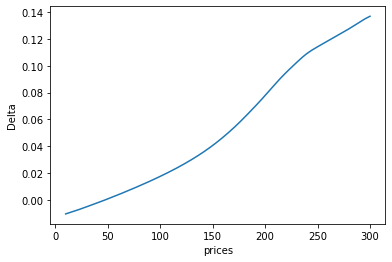

In [ ]:
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S):
    inputs = torch.tensor([[110.0, 100.0, S, 0.35, 0.1, 0.05] + ([110.0, 100.0, 120.0, 0.35, 0.1, 0.05]*9)]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(10, 300, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

Calculating the second order derivative is easy in PyTorch too. We just need to apply the `grad` function twice. Use this mechanism, we can calculate the second order derivatives $\frac{\partial^2 P}{\partial K \partial S_0}$, $\frac{\partial^2 P}{\partial B \partial S_0}$, $\frac{\partial^2 P}{\partial S_0^2}$, $\frac{\partial^2 P}{\partial \sigma \partial S_0}$, $\frac{\partial^2 P}{\partial \mu \partial S_0}$, $\frac{\partial^2 P}{\partial r \partial S_0}$ in the following example.

In [ ]:
import torch
from torch import Tensor
from torch.autograd import Variable
from torch.autograd import grad
from torch import nn

inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05]*10]).cuda()
inputs.requires_grad = True
x = model(inputs)

# instead of using loss.backward(), use torch.autograd.grad() to compute gradients
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
loss_grads = grad(x, inputs, create_graph=True)
drv = grad(loss_grads[0][0][2], inputs)
drv

(tensor([[-4.2155e-04,  1.8928e-05,  4.3383e-04,  1.9160e-03,  3.1185e-02,
          -4.2699e-02, -2.8334e-05, -5.3102e-06,  2.7251e-05,  3.5252e-03,
           5.2099e-03,  8.4961e-03, -5.2523e-05, -5.1632e-05,  5.2887e-05,
           6.8761e-03, -1.2509e-03, -1.8901e-02, -1.4810e-05, -4.1013e-05,
           3.1564e-05, -3.5778e-03, -4.4467e-03,  3.3437e-03, -3.3124e-05,
          -6.2398e-05,  3.8438e-05,  2.4191e-03,  1.0250e-02,  8.0289e-03,
          -3.5385e-05, -1.0523e-05,  1.6792e-05,  3.9085e-03, -3.8925e-03,
          -4.1625e-03, -3.3123e-05, -3.7600e-05,  3.7231e-05,  2.2619e-03,
           8.5746e-03, -1.9339e-03, -1.0539e-04, -2.4071e-05,  1.0590e-04,
           3.3561e-03, -9.1576e-04, -1.9725e-02, -3.2639e-05, -2.4224e-05,
           4.1162e-05,  5.0516e-05,  2.5105e-02, -1.4045e-03, -1.3165e-04,
          -7.4675e-05,  1.3472e-04,  4.6619e-03,  4.0463e-03, -4.2377e-03]],
        device='cuda:0'),)

Gamma is the second order differenation of `S`. We can plot the the Gamma curve as a function of the stock price

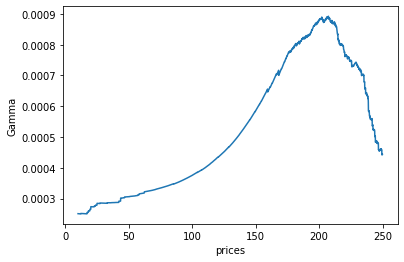

In [ ]:
import pylab
import numpy as np
def compute_gamma(S):
    inputs = torch.tensor([[110.0, 100.0, S, 0.35, 0.1, 0.05] + ([110.0, 100.0, 120.0, 0.35, 0.1, 0.05]*9)]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    loss_grads = grad(x, inputs, create_graph=True)
    drv = grad(loss_grads[0][0][2], inputs)
    return drv[0][0][2]

prices = np.arange(10, 250, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_gamma(p).item())
fig2 = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Gamma')
fig2

[Implied volatility](https://en.wikipedia.org/wiki/Implied_volatility) is the forecasted volatility of the underlying asset based on the quoted prices of the option. It is the reverse mapping of price to the option parameter given the model which is hard to do with the Monte Carlo simulation approach. But if we have the deep learning pricing model, it is an easy task. We can first plot the relationship between volatility and the option price

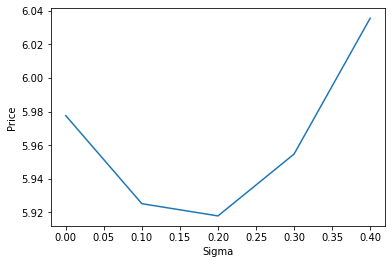

In [ ]:
import pylab
import numpy as np
def compute_price(sigma):
    inputs = torch.tensor([[110.0, 100.0, 120.0, sigma, 0.1, 0.05] + ([110.0, 100.0, 120.0, 0.35, 0.1, 0.05]*9)]).cuda()
    x = model(inputs.float())
    #x = model(inputs)
    return x.item()
sigmas = np.arange(0, 0.5, 0.1)
prices = []
for s in sigmas:
    prices.append(compute_price(s))
fig3 = pylab.plot(sigmas, prices)
pylab.xlabel('Sigma')
pylab.ylabel('Price')
fig3

Given the prices `P`, the implied volatility is the root of the function `compute_price`. We can use bisection to find the root.

In [ ]:
def bisection_root(small, large, fun, target, EPS=1e-6):
    if fun(large) - target < 0:
        print('upper bound is too small')
        return None
    if fun(small) - target > 0:
        print('lower bound is too large')
        return None
    while large - small > EPS:
        mid = (large + small) / 2.0
        if fun(mid) - target >= 0:
            large = mid
        else:
            small = mid
    mid = (large + small) / 2.0
    return mid, abs(fun(mid) - target)
quoted_price = 16.0
sigma, err = bisection_root(0, 0.5, compute_price, quoted_price)
print('implied volativity', sigma, 'error', err)     

upper bound is too small


TypeError: ignored